# 学生管理系统 - 大规模真实成绩数据集 + 数据库设计示例

本 Notebook 结合《Java 面向对象综合实训》的要求，使用一个规模较大的真实考试成绩数据集，帮助你完成学生管理系统的 **数据与数据库部分**：

- 从公开数据源下载 1000 条学生成绩记录；
- 整理为“学生表 / 课程表 / 选课表 / 成绩表”等结构；
- 导出为 CSV，方便导入 MySQL；
- 用 SQLite 演示建表、导入和查询逻辑，对应 Java 中的 JDBC 操作。

> 数据来源：GitHub 仓库 `rashida048/Datasets` 中的 `StudentsPerformance.csv`（原始数据来自 Kaggle“Students Performance in Exams”数据集）。

## 1. 实训功能需求简要回顾

- 用户注册：学号、姓名、性别、年龄、专业等基本信息。
- 用户登录：学生和管理员两种角色。
- 学生信息管理（管理员，选做）：增删改查学生信息。
- 课程信息管理（管理员，选做）：增删改查课程信息。
- 选课管理（学生，选做）：选课、查看已选课程、退选课程。
- 成绩管理（管理员，选做）：录入、查询学生成绩。

下面的 Notebook 不涉及 Java Swing 界面，只负责准备一套**结构清晰、数据量充足**的数据库样例数据。

## 2. 环境准备

需要的 Python 库：

- `pandas`
- `numpy`
- `sqlite3`（标准库）


In [68]:
import pandas as pd
import numpy as np
import sqlite3
from pathlib import Path

data_dir = Path("data")
data_dir.mkdir(exist_ok=True)
data_dir.resolve()

PosixPath('/Users/lili/3654456256/data')

In [69]:
from pathlib import Path
import requests
import matplotlib.pyplot as plt
from matplotlib import font_manager

# 全局设置中文字体，避免所有图形中的中文出现乱码
font_path = Path('NotoSansCJKsc-Regular.otf')
if not font_path.exists():
    url = 'https://github.com/googlefonts/noto-cjk/raw/main/Sans/OTF/SimplifiedChinese/NotoSansCJKsc-Regular.otf'
    r = requests.get(url, timeout=30)
    r.raise_for_status()
    font_path.write_bytes(r.content)

font_manager.fontManager.addfont(str(font_path))
plt.rcParams['font.family'] = ['Noto Sans CJK SC']
plt.rcParams['font.sans-serif'] = ['Noto Sans CJK SC']
plt.rcParams['axes.unicode_minus'] = False


## 3. 下载 StudentsPerformance 真实数据集

原始数据集包含 1000 名学生在数学、阅读、写作三科的成绩，以及性别、家庭背景、是否参加课前准备课程等信息。下面直接从 GitHub 下载 CSV 文件。

In [70]:
url = "https://github.com/rashida048/Datasets/raw/refs/heads/master/StudentsPerformance.csv"
sp_raw = pd.read_csv(url)
len(sp_raw), sp_raw.head()

(1000,
    gender race/ethnicity parental level of education         lunch  \
 0  female        group B           bachelor's degree      standard   
 1  female        group C                some college      standard   
 2  female        group B             master's degree      standard   
 3    male        group A          associate's degree  free/reduced   
 4    male        group C                some college      standard   
 
   test preparation course  math score  reading score  writing score  
 0                    none          72             72             74  
 1               completed          69             90             88  
 2                    none          90             95             93  
 3                    none          47             57             44  
 4                    none          76             78             75  )

可以看到每一行是一名学生，包含以下字段：

- `gender`
- `race/ethnicity`
- `parental level of education`
- `lunch`
- `test preparation course`
- `math score`
- `reading score`
- `writing score`

接下来我们会把这些信息整理成适合“学生管理系统”的几张表。

## 4. 学生信息表 `students`

根据实训要求，学生表至少需要：学号、姓名、性别、年龄、专业等。原始数据中没有学号、姓名和年龄，我们按如下方式构造：

- 学号：按顺序生成 `S0001` ~ `S1000`；
- 姓名：简单使用 `Student001` 这类占位符（实际项目可以改成真实姓名）；
- 年龄：在 18~22 岁之间随机生成；
- 专业：在“计算机科学与技术 / 软件工程 / 信息管理与信息系统 / 大数据技术 / 网络工程”中随机分配。

其他字段（性别、家庭背景等）全部直接来自原始数据集。

In [71]:
num_students = len(sp_raw)

student_ids = [f"S{idx:04d}" for idx in range(1, num_students + 1)]
names = [f"Student{idx:03d}" for idx in range(1, num_students + 1)]

rng = np.random.default_rng(seed=123)
ages = rng.integers(18, 23, size=num_students)
majors = ["计算机科学与技术", "软件工程", "信息管理与信息系统", "大数据技术", "网络工程"]
major_choices = rng.choice(majors, size=num_students)

students_df = pd.DataFrame({
    "student_id": student_ids,
    "name": names,
    "gender": sp_raw["gender"],
    "race_ethnicity": sp_raw["race/ethnicity"],
    "parental_education": sp_raw["parental level of education"],
    "lunch": sp_raw["lunch"],
    "test_preparation_course": sp_raw["test preparation course"],
    "age": ages,
    "major": major_choices,
})

students_df.head()

,student_id,name,gender,race_ethnicity,parental_education,lunch,test_preparation_course,age,major
0,S0001,Student001,female,group B,bachelor's degree,standard,none,18,信息管理与信息系统
1,S0002,Student002,female,group C,some college,standard,completed,21,网络工程
2,S0003,Student003,female,group B,master's degree,standard,none,20,网络工程
3,S0004,Student004,male,group A,associate's degree,free/reduced,none,18,计算机科学与技术
4,S0005,Student005,male,group C,some college,standard,none,22,计算机科学与技术


## 5. 课程信息表 `courses`

原始数据集中每个学生都有三门科目的成绩：数学、阅读、写作。我们可以把它们视为三门课程：

- `C001`：数学（4 学分）
- `C002`：阅读（2 学分）
- `C003`：写作（2 学分）

后续如果你想扩展课程信息（课程介绍、教师、上课时间等），可以在此表基础上继续增加字段。

In [72]:
courses_data = [
    ("C001", "数学", "math score", 4),
    ("C002", "阅读", "reading score", 2),
    ("C003", "写作", "writing score", 2),
]

courses_df = pd.DataFrame(courses_data, columns=["course_id", "course_name", "score_column", "credit"])
courses_df

,course_id,course_name,score_column,credit
0,C001,数学,math score,4
1,C002,阅读,reading score,2
2,C003,写作,writing score,2


## 6. 选课表 `enrollments` 与成绩表 `grades`

原始数据集中每一行是一名学生在三门课上的成绩，我们可以利用 `pandas.melt` 将列转行：

- 对每位学生生成三条记录，分别对应数学、阅读、写作三门课；
- 这样就得到一个标准化的“学生-课程-成绩”结构，方便做选课和成绩管理；
- 为简单起见，这里所有记录的学期统一设为 `2024春季学期`（你也可以根据需要扩展为多个学期）。

In [73]:
# 加入 student_id 字段
sp_with_ids = sp_raw.copy()
sp_with_ids["student_id"] = student_ids

melted = sp_with_ids.melt(
    id_vars=["student_id"],
    value_vars=["math score", "reading score", "writing score"],
    var_name="score_type",
    value_name="score",
)

type_to_course = {
    "math score": "C001",
    "reading score": "C002",
    "writing score": "C003",
}

melted["course_id"] = melted["score_type"].map(type_to_course)
melted["semester"] = "2024春季学期"

enrollments_df = melted[["student_id", "course_id", "semester"]].copy()
grades_df = melted[["student_id", "course_id", "score"]].copy()

len(enrollments_df), enrollments_df.head()

(3000,
   student_id course_id  semester
 0      S0001      C001  2024春季学期
 1      S0002      C001  2024春季学期
 2      S0003      C001  2024春季学期
 3      S0004      C001  2024春季学期
 4      S0005      C001  2024春季学期)

可以看到此时：

- 学生数量：1000
- 课程数量：3
- 选课记录数量：1000 × 3 = 3000（数据量已经比较可观，适合做实训演示和查询练习）。

## 7. 导出整理后的 CSV 文件

这些 CSV 可以作为 MySQL 的初始化数据文件，在图形化工具中导入，或者用 SQL 语句批量插入。

In [74]:
students_csv = data_dir / "students_sp.csv"
courses_csv = data_dir / "courses_sp.csv"
enrollments_csv = data_dir / "enrollments_sp.csv"
grades_csv = data_dir / "grades_sp.csv"

students_df.to_csv(students_csv, index=False, encoding="utf-8-sig")
courses_df.to_csv(courses_csv, index=False, encoding="utf-8-sig")
enrollments_df.to_csv(enrollments_csv, index=False, encoding="utf-8-sig")
grades_df.to_csv(grades_csv, index=False, encoding="utf-8-sig")

students_csv, courses_csv, enrollments_csv, grades_csv

(PosixPath('data/students_sp.csv'),
 PosixPath('data/courses_sp.csv'),
 PosixPath('data/enrollments_sp.csv'),
 PosixPath('data/grades_sp.csv'))

## 8. 使用 SQLite 演示建库与导入

下面在本地创建一个 SQLite 数据库 `student_management_sp.db`，并定义 4 张表：

1. `students`：学生基本信息；
2. `courses`：课程信息；
3. `enrollments`：选课记录；
4. `grades`：成绩记录。

表结构可以直接迁移到 MySQL，然后在 Java 程序中通过 JDBC 操作。

In [75]:
db_path = Path("student_management_sp.db")
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# 学生表
cursor.execute(
    """
    CREATE TABLE IF NOT EXISTS students (
        student_id              TEXT PRIMARY KEY,
        name                    TEXT NOT NULL,
        gender                  TEXT,
        race_ethnicity          TEXT,
        parental_education      TEXT,
        lunch                   TEXT,
        test_preparation_course TEXT,
        age                     INTEGER,
        major                   TEXT
    );
    """
)

# 课程表
cursor.execute(
    """
    CREATE TABLE IF NOT EXISTS courses (
        course_id    TEXT PRIMARY KEY,
        course_name  TEXT,
        score_column TEXT,
        credit       INTEGER
    );
    """
)

# 选课表
cursor.execute(
    """
    CREATE TABLE IF NOT EXISTS enrollments (
        id         INTEGER PRIMARY KEY AUTOINCREMENT,
        student_id TEXT NOT NULL,
        course_id  TEXT NOT NULL,
        semester   TEXT,
        FOREIGN KEY (student_id) REFERENCES students(student_id),
        FOREIGN KEY (course_id)  REFERENCES courses(course_id)
    );
    """
)

# 成绩表
cursor.execute(
    """
    CREATE TABLE IF NOT EXISTS grades (
        id         INTEGER PRIMARY KEY AUTOINCREMENT,
        student_id TEXT NOT NULL,
        course_id  TEXT NOT NULL,
        score      REAL,
        FOREIGN KEY (student_id) REFERENCES students(student_id),
        FOREIGN KEY (course_id)  REFERENCES courses(course_id)
    );
    """
)

conn.commit()
db_path.resolve()

PosixPath('/Users/lili/3654456256/student_management_sp.db')

### 8.1 导入数据到 SQLite

使用 `pandas.DataFrame.to_sql` 快速导入数据，对应到 MySQL 中可以改成批量 `INSERT` 或使用导入工具。

In [76]:
students_df.to_sql("students", conn, if_exists="replace", index=False)
courses_df.to_sql("courses", conn, if_exists="replace", index=False)
enrollments_df.to_sql("enrollments", conn, if_exists="replace", index=False)
grades_df.to_sql("grades", conn, if_exists="replace", index=False)

conn.commit()

pd.read_sql_query("SELECT * FROM students LIMIT 5", conn)

,student_id,name,gender,race_ethnicity,parental_education,lunch,test_preparation_course,age,major
0,S0001,Student001,female,group B,bachelor's degree,standard,none,18,信息管理与信息系统
1,S0002,Student002,female,group C,some college,standard,completed,21,网络工程
2,S0003,Student003,female,group B,master's degree,standard,none,20,网络工程
3,S0004,Student004,male,group A,associate's degree,free/reduced,none,18,计算机科学与技术
4,S0005,Student005,male,group C,some college,standard,none,22,计算机科学与技术


### 8.2 示例查询：某个学生的全部课程成绩

下面演示一个常见需求：给定学号，查询该学生选修的全部课程及成绩。

In [77]:
example_student_id = students_df.iloc[0]["student_id"]
print("示例学号:", example_student_id)

query = """
SELECT s.student_id,
       s.name,
       c.course_name,
       e.semester,
       g.score
FROM students s
JOIN enrollments e ON s.student_id = e.student_id
JOIN courses c     ON e.course_id  = c.course_id
JOIN grades g      ON g.student_id = s.student_id AND g.course_id = c.course_id
WHERE s.student_id = ?
ORDER BY c.course_id;
"""

pd.read_sql_query(query, conn, params=[example_student_id])

示例学号: S0001


,student_id,name,course_name,semester,score
0,S0001,Student001,数学,2024春季学期,72
1,S0001,Student001,阅读,2024春季学期,72
2,S0001,Student001,写作,2024春季学期,74


## 9. 成绩分布与可视化

下面利用前面下载的 `StudentsPerformance` 数据集画一些统计图表，让 Notebook 更直观好看，也方便在课程报告中截图使用。

In [78]:
import matplotlib.pyplot as plt
from matplotlib import font_manager

# 设置中文字体，避免图中出现乱码
font_candidates = ['SimHei', 'Microsoft YaHei', 'PingFang SC', 'STHeiti', 'Songti SC']
available = {f.name for f in font_manager.fontManager.ttflist}
for f in font_candidates:
    if f in available:
        plt.rcParams['font.sans-serif'] = [f]
        break
else:
    # 没有常见中文字体时，仍然使用默认字体
    plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False


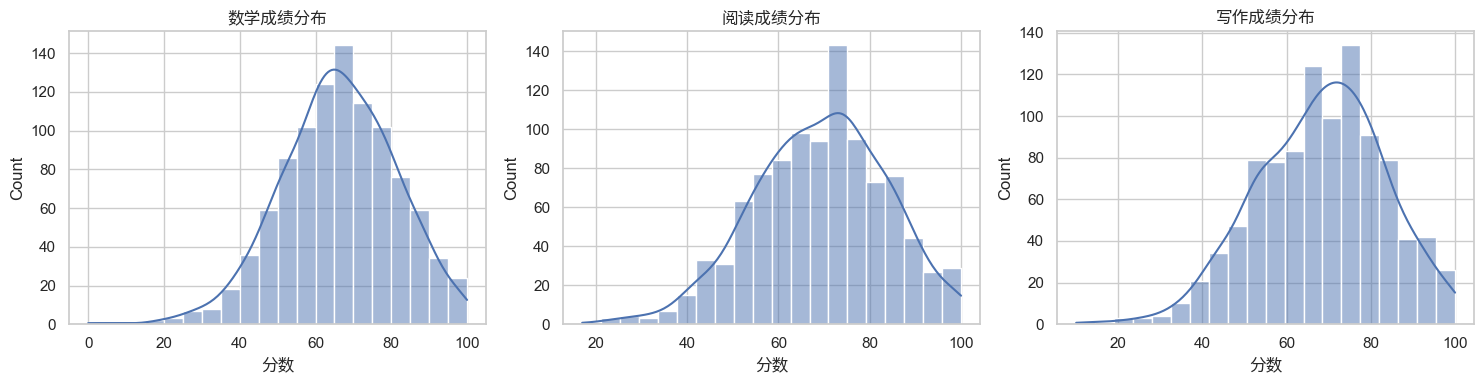

In [79]:
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager

# 使用指定中文字体绘制成绩直方图，避免中文乱码
font_path = Path('NotoSansCJKsc-Regular.otf')
font_manager.fontManager.addfont(str(font_path))
zh_font = font_manager.FontProperties(fname=str(font_path))

sns.set(style='whitegrid')

cols = ['math score', 'reading score', 'writing score']
titles = ['数学成绩分布', '阅读成绩分布', '写作成绩分布']

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, col, title in zip(axes, cols, titles):
    sns.histplot(sp_raw[col], kde=True, bins=20, ax=ax)
    ax.set_title(title, fontproperties=zh_font)
    ax.set_xlabel('分数', fontproperties=zh_font)

plt.tight_layout()
plt.show()


,math score,reading score,writing score
gender,,,
female,63.633205,72.608108,72.467181
male,68.728216,65.473029,63.311203


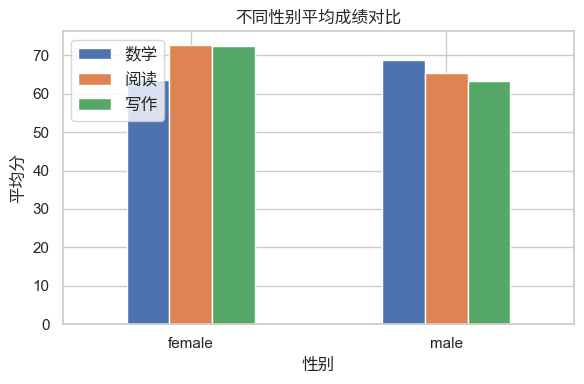

In [80]:
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import font_manager

font_path = Path('NotoSansCJKsc-Regular.otf')
font_manager.fontManager.addfont(str(font_path))
zh_font = font_manager.FontProperties(fname=str(font_path))

avg_scores_gender = sp_raw.groupby('gender')[['math score', 'reading score', 'writing score']].mean()
display(avg_scores_gender)

ax = avg_scores_gender.plot(kind='bar', figsize=(6, 4))
ax.set_title('不同性别平均成绩对比', fontproperties=zh_font)
ax.set_ylabel('平均分', fontproperties=zh_font)
ax.set_xlabel('性别', fontproperties=zh_font)
ax.legend(['数学', '阅读', '写作'], loc='upper left', prop=zh_font)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


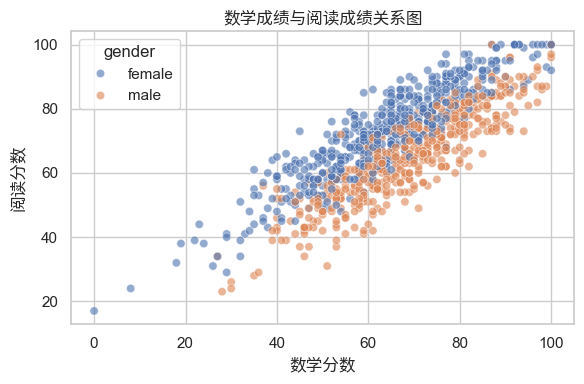

In [81]:
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager

font_path = Path('NotoSansCJKsc-Regular.otf')
font_manager.fontManager.addfont(str(font_path))
zh_font = font_manager.FontProperties(fname=str(font_path))

plt.figure(figsize=(6, 4))
sns.scatterplot(data=sp_raw, x='math score', y='reading score', hue='gender', alpha=0.6)
plt.title('数学成绩与阅读成绩关系图', fontproperties=zh_font)
plt.xlabel('数学分数', fontproperties=zh_font)
plt.ylabel('阅读分数', fontproperties=zh_font)
plt.tight_layout()
plt.show()
